In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
from collections import Counter
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.op.analysis import Run_Manager
foundation = learn
sys.modules['foundation'] = learn

from sklearn.decomposition import PCA
import sklearn.datasets

# from src import sample_full_interventions, response_mat

# import gpumap
from c3linearize import linearize, class_graph

In [2]:
save_figure_kwargs = dict(
#     root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\n21_supplement',
#     root = r'/is/ei/fleeb/workspace/code/projects/learn_rep/figures/icml',
    root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\icml22',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.title = '3D-Shapes'

info.device = 'cuda'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

color_idents = {}
info.colors = {n:f'C{n}' for n in range(10)}
def _get_color(idx):
    if isinstance(idx, int):
        idx = idx%len(info.colors)
    if idx in color_idents:
        return _get_color(color_idents[idx])
    return info.colors.get(idx, idx)


preset_figure_info(info)
print(info)

t{fsize, cut, title, device, results_name, small_font_size, medium_font_size, large_font_size, colors}


In [63]:
raw = '''AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928	celeba_ae0_e-c16_d-c16_mish_210125-132401	rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908
VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340	celeba_vae1_e-c16_d-c16_mish_210125-132401	rfd_vae1_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214205
VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340	celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817	rfd_vae2_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214633
VAE4	3ds_vae4_e-c12_d-c12_mish_210125-140302	toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852	celeba_vae4_e-c16_d-c16_mish-lrp0004_210201-101817	
VAE8	3ds_vae8_e-c12_d-c12_mish_210125-140550	toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853		
WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340	celeba_wae10_e-c16_d-c16_mish_210201-000430	rfd_wae10_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-215009
WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340		
WAE1000	3ds_wae1000_e-c12_d-c12_mish_210125-221142	toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339		
AE S2	3ds_ae_e-c12_d-s2_mish_210131-150237	toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829		
AE S2 nosplit	3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234	toy_ae_e-c12_d-s2_nosplit-mish_210131-150234	sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	real_ae_e-c12_d-s2_nosplit-mish_210131-150234		
AE S3	3ds_ae_e-c12_d-s3_mish_210201-021841	toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829		
AE S3 nosplit	3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234	toy_ae_e-c12_d-s3_nosplit-mish_210131-150236	sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	real_ae_e-c12_d-s3_nosplit-mish_210131-150234		
AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339		
AE S4 nosplit	3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234	toy_ae_e-c12_d-s4_nosplit-mish_210131-150235	sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	real_ae_e-c12_d-s4_nosplit-mish_210131-150234		
AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339		
AE S6 nosplit	3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234	toy_ae_e-c12_d-s6_nosplit-mish_210131-150236	sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	real_ae_e-c12_d-s6_nosplit-mish_210131-150236		
AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish-seed5_210131-150235	celeba_ae0_e-c16_d-s16_mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256_210524-161708
AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256-nosplit_210525-122527
VAE1 L2	3ds_vae1_e-l2_d-l2_mish_210131-150235	toy_vae1_e-l2_d-l2_mish_210131-150234	sim_vae1_e-l2_d-l2_mish_210131-150238	real_vae1_e-l2_d-l2_mish_210131-150240		
VAE1 L3	3ds_vae1_e-l3_d-l3_mish_210131-150235	toy_vae1_e-l3_d-l3_mish_210131-150234	sim_vae1_e-l3_d-l3_mish_210131-150236	real_vae1_e-l3_d-l3_mish_210131-150236		
VAE1 L4	3ds_vae1_e-l4_d-l4_mish_210125-134914	toy_vae1_e-l4_d-l4_mish_210131-150235	sim_vae1_e-l4_d-l4_mish_210127-231449	real_vae1_e-l4_d-l4_mish_210131-150236		
VAE1 L6	3ds_vae1_e-l6_d-l6_mish_210125-140021	toy_vae1_e-l6_d-l6_mish_210131-150235	sim_vae1_e-l6_d-l6_mish_210127-231447	real_vae1_e-l6_d-l6_mish_210131-150236		
VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847	celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237	rfd_vae1_e-l16_d-l16_d16-strd-trans-lrp00005-bs64-ch256_210524-214809
TCVAE 1	3ds_tcvae1_e-c12_d-c12_mish-b1_220126-001041	toy_tcvae1_e-c12_d-c12_mish-b1_220126-003646	sim_tcvae1_e-c12_d-c12_mish-b1_220126-003646	real_tcvae1_e-c12_d-c12_mish-b1_220126-003708	celeba_tcvae1_e-c16_d-c16_mish-b1_220126-002625	
TCVAE 4	3ds_tcvae1_e-c12_d-c12_mish-b4_220126-001031	toy_tcvae1_e-c12_d-c12_mish-b4_220126-003644	sim_tcvae1_e-c12_d-c12_mish-b4_220126-003647	real_tcvae1_e-c12_d-c12_mish-b4_220126-003646	celeba_tcvae1_e-c16_d-c16_mish-b4_220126-002615	
FVAE 1	3ds_fvae1_e-c12_d-c12_mish_220125-194411	toy_fvae1_e-c12_d-c12_mish_220126-003701	sim_fvae1_e-c12_d-c12_mish_220126-003646	real_fvae1_e-c12_d-c12_mish_220126-003704	celeba_fvae1_e-c16_d-c16_mish_220125-194732	
FVAE 4	3ds_fvae4_e-c12_d-c12_mish_220125-195100	toy_fvae4_e-c12_d-c12_mish_220126-123210	sim_fvae4_e-c12_d-c12_mish_220126-123212	real_fvae4_e-c12_d-c12_mish_220126-123212	celeba_fvae2_e-c16_d-c16_mish_220125-194748	
AE seed 2	3ds_ae_e-c12_d-c12_mish-seed2_210131-230456					
AE seed 3	3ds_ae_e-c12_d-c12_mish-seed3_210131-230456					
AE seed 4	3ds_ae_e-c12_d-c12_mish-seed4_210131-230456					
AE seed 5	3ds_ae_e-c12_d-c12_mish-seed5_210131-230456					
VAE1 seed 2	3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457					
VAE1 seed 3	3ds_vae1_e-c12_d-c12_mish-seed3_210131-230501					
VAE1 seed 4	3ds_vae1_e-c12_d-c12_mish-seed4_210131-230501					
VAE1 seed 5	3ds_vae1_e-c12_d-c12_mish-seed5_210131-230500					
VAE2 seed 2	3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501					
VAE2 seed 3	3ds_vae2_e-c12_d-c12_mish-seed3_210131-230459					
VAE2 seed 4	3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503					
VAE2 seed 5	3ds_vae2_e-c12_d-c12_mish-seed5_210131-230501					
WAE10 seed 2	3ds_wae10_e-c12_d-c12_mish-seed2_210201-021010					
WAE10 seed 3	3ds_wae10_e-c12_d-c12_mish-seed3_210201-021013					
WAE10 seed 4	3ds_wae10_e-c12_d-c12_mish-seed4_210201-021011					
WAE10 seed 5	3ds_wae10_e-c12_d-c12_mish-seed5_210201-021840					
WAE100 seed 2	3ds_wae100_e-c12_d-c12_mish-seed2_210131-230501					
WAE100 seed 3	3ds_wae100_e-c12_d-c12_mish-seed3_210131-230503					
WAE100 seed 4	3ds_wae100_e-c12_d-c12_mish-seed4_210131-230503					
WAE100 seed 5	3ds_wae100_e-c12_d-c12_mish-seed5_210131-230503					
AE S4 seed 2	3ds_ae_e-c12_d-s4_mish-seed2_210131-230504					
AE S4 seed 3	3ds_ae_e-c12_d-s4_mish-seed3_210131-230506					
AE S4 seed 4	3ds_ae_e-c12_d-s4_mish-seed4_210131-230506					
AE S4 seed 5	3ds_ae_e-c12_d-s4_mish-seed5_210131-230505					
AE S6 seed 2	3ds_ae_e-c12_d-s6_mish-seed2_210131-230505					
AE S6 seed 3	3ds_ae_e-c12_d-s6_mish-seed3_210131-230503					
AE S6 seed 4	3ds_ae_e-c12_d-s6_mish-seed4_210131-230505					
AE S6 seed 5	3ds_ae_e-c12_d-s6_mish-seed5_210131-230504					
AE S12 seed 2	3ds_ae_e-c12_d-s12_seed3-mish_210126-004805					
AE S12 seed 3	3ds_ae_e-c12_d-s12_mish-seed5_210131-150235					
AE S12 seed 4	3ds_ae_e-c12_d-s12_mish-seed8_210201-035456					
AE S12 seed 5	3ds_ae_e-c12_d-s12_mish-seed6_210201-035456					
AE S12 nosplit seed 2	3ds_ae_e-c12_d-s12_nosplit-mish-seed3_210131-230502					
AE S12 nosplit seed 3	3ds_ae_e-c12_d-s12_nosplit-mish-seed5_210131-230503					
AE S12 nosplit seed 4	3ds_ae_e-c12_d-s12_nosplit-mish-seed4_210131-230506					
AE S12 nosplit seed 5	3ds_ae_e-c12_d-s12_mish-nosplit-seed7_210201-035456					
VAE1 L12 seed 2	3ds_vae1_e-l12_d-l12_mish-seed2_210131-230506					
VAE1 L12 seed 3	3ds_vae1_e-l12_d-l12_mish-seed3_210131-230505					
VAE1 L12 seed 4	3ds_vae1_e-l12_d-l12_mish-seed4_210131-230507					
VAE1 L12 seed 5	3ds_vae1_e-l12_d-l12_mish-seed5_210131-230507					
TCVAE 1 seed 2	3ds_tcvae1_e-c12_d-c12_mish-b1-s2_220126-004444					
TCVAE 1 seed 3	3ds_tcvae1_e-c12_d-c12_mish-b1-s3_220126-004435
TCVAE 1 seed 4	3ds_tcvae1_e-c12_d-c12_mish-b1-s4_220126-004443					
TCVAE 1 seed 5	3ds_tcvae1_e-c12_d-c12_mish-b1-s5_220126-004444					
TCVAE 4 seed 2	3ds_tcvae4_e-c12_d-c12_mish-b4-s2_220126-004445					
TCVAE 4 seed 3	3ds_tcvae4_e-c12_d-c12_mish-b4-s3_220126-004443					
TCVAE 4 seed 4	3ds_tcvae4_e-c12_d-c12_mish-b4-s4_220126-004444					
TCVAE 4 seed 5	3ds_tcvae4_e-c12_d-c12_mish-b4-s5_220126-004445					
FVAE 1 seed 2	3ds_fvae1_e-c12_d-c12_mish-s2_220126-004451					
FVAE 1 seed 3	3ds_fvae1_e-c12_d-c12_mish-s3_220126-004444					
FVAE 1 seed 4	3ds_fvae1_e-c12_d-c12_mish-s4_220126-004450					
FVAE 1 seed 5	3ds_fvae1_e-c12_d-c12_mish-s5_220126-004435					
FVAE 4 seed 2	3ds_fvae4_e-c12_d-c12_mish-s2_220126-004445					
FVAE 4 seed 3	3ds_fvae4_e-c12_d-c12_mish-s3_220126-004448					
FVAE 4 seed 4	3ds_fvae4_e-c12_d-c12_mish-s4_220126-004440					
FVAE 4 seed 5	3ds_fvae4_e-c12_d-c12_mish-s5_220126-004443					'''

base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':r'$\beta$VAE', 'WAE10':'WAE', 'WAE100':'WAE2', 'AE S12':'SAE-12', 'AE S4':'SAE-4', 'AE S6': 'SAE-6', 'AE S3':'SAE-3', 'AE S2': 'SAE-2', 
               'VAE1 L12':'VLAE-12', 'VAE1 L6':'VLAE-6', 'VAE1 L4':'VLAE-4', 'VAE1 L3':'VLAE-3', 'VAE1 L2':'VLAE-2', 
               'AE S12 nosplit':'AdaAE-12', 'AE S6 nosplit':'AdaAE-6', 'AE S4 nosplit':'AdaAE-4', 'AE S3 nosplit':'AdaAE-3', 'AE S2 nosplit':'AdaAE-2',
              'TCVAE 1': 'TCVAE', 'TCVAE 4': r'$\beta$TCVAE', 'FVAE 1': 'FVAE', 'FVAE 4': r'$\beta$FVAE'}

arch_order = ['Structural', 'Adaptive', 'Ladder', 'Baseline']
color_idents.update({'Baseline':1, 'Structural':0, 'Ladder':3, 'Adaptive':2})
archs = {
    'Baseline': ['AE', 'VAE1', 'VAE2', 'WAE10', 'WAE100', 'TCVAE 1', 'TCVAE 4', 'FVAE 1', 'FVAE 4', ],
    'Structural': ['AE S12', 'AE S4', 'AE S6', 'AE S3', 'AE S2', ],
    'Ladder': ['VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2', ],
    'Adaptive': ['AE S12 nosplit', 'AE S6 nosplit', 'AE S4 nosplit', 'AE S3 nosplit', 'AE S2 nosplit', ],
}
model_archs = {m:a for a, ms in archs.items() for m in ms}


remove_runs = ['VAE4', 'VAE8', 'WAE100', 'WAE1000', 'TCVAE 1', 'FVAE 4',
               'AE S2 nosplit', 'AE S4 nosplit', 'AE S3 nosplit',
               'sim_ae_e-c12_d-s6_nosplit-mish_210127-231313',
               '3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457', '3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501', 
               '3ds_ae_e-c12_d-s6_mish-seed4_210131-230505',
               'celeba_vae1_e-l16_d-l16_mish_210125-132401', 'celeba_wae10_e-c16_d-c16_mish_210201-000430',
               #'toy_ae_e-c12_d-s12_mish-seed2_210126-122537', 'toy_ae_e-c12_d-s12_mish_210125-222233',
              '3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503',
#                'VAE1 L6', 'VAE1 L4', 
               'AE S3', 'VAE1 L3', 'AE S6 nosplit', 'AE S2', 'FVAE 4', 'VAE1 L2', 'TCVAE 1']

dsnames = ['3ds', 'toy', 'sim', 'real', 'celeba', 'rfd']
dscodes = {'3ds': '3D-Shapes', 'toy': 'MPI3D-Toy', 'sim': 'MPI3D-Sim', 'real': 'MPI3D-Real', 'celeba':'CelebA', 'rfd':'RFD'}

def _fix(title, *other):
    title = title.replace('Copy of ', '')
    if 'seed' in title:
        num = int(title[-1])
        title = title[:-7]
    return title, *other

model_tbl = [_fix(*row.split('\t')) for row in raw.split('\n')]
model_tbl = [row for row in model_tbl if row is not None]

dsgs = {}
gnames = {}
for g, *ns in model_tbl:
    if g not in remove_runs:
        for ds, n in zip(dsnames, ns):
            if len(n):
                if ds not in dsgs:
                    dsgs[ds] = {}
                if n not in remove_runs:
                    if g not in dsgs[ds]:
                        dsgs[ds][g] = []
                    if n not in dsgs[ds][g]:
                        dsgs[ds][g].append(n)

dsname = 'real'

gnames = dsgs[dsname]
info.title = dscodes[dsname]

if dsname in {'celeba', 'rfd'}:
    base_titles['AE S12'] = 'SAE-16'
    base_titles['VAE1 L12'] = 'VLAE-16'
    base_titles['AE S12 nosplit'] = 'AdaAE-16'
    
print(tabulate([[g, len(gn), '\n'.join(gn)] for g, gn in gnames.items()], headers=['Group', '#', 'Names']))
len(gnames), len(model_tbl)

Group             #  Names
--------------  ---  ----------------------------------------------
AE                1  real_ae_e-c12_d-c12_mish_210126-035928
VAE1              1  real_vae1_e-c12_d-c12_mish_210126-123340
VAE2              1  real_vae2_e-c12_d-c12_mish_210126-123340
WAE10             1  real_wae10_e-c12_d-c12_mish_210126-123340
AE S4             1  real_ae_e-c12_d-s4_mish_210126-123339
AE S6             1  real_ae_e-c12_d-s6_mish_210126-123339
AE S12            1  real_ae_e-c12_d-s12_mish-seed5_210131-150235
AE S12 nosplit    1  real_ae_e-c12_d-s12_nosplit-mish_210127-231851
VAE1 L4           1  real_vae1_e-l4_d-l4_mish_210131-150236
VAE1 L6           1  real_vae1_e-l6_d-l6_mish_210131-150236
VAE1 L12          1  real_vae1_e-l12_d-l12_mish_210127-231847
TCVAE 4           1  real_tcvae1_e-c12_d-c12_mish-b4_220126-003646
FVAE 1            1  real_fvae1_e-c12_d-c12_mish_220126-003704


(13, 83)

In [64]:
# AE S12 seed 3	3ds_ae_e-c12_d-s12_mish-seed2_210131-150235					

In [65]:
group_order = ['AE S12', 'AE S4', 'AE S6', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 1', 'TCVAE 4', 'FVAE 1', 'FVAE 4']
group_order = ['AE S12', 'AE S4', 'AE S6', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 4', 'FVAE 1', 'VAE1 L4', 'VAE1 L6']
missing = set(group_order).symmetric_difference(set(gnames))
assert not missing, f'{missing}'

In [66]:
srcroots = [Path(r'/is/ei/fleeb/workspace/chome/old_trained_nets'), Path(r'/is/ei/fleeb/workspace/chome/saved_models/sae_baselines/')]
# srcroots = [Path(r'C:\Users\anwan\Documents\workspace\sae\final')]
srcroots = [Path(r'C:\Users\anwan\Documents\workspace\sae\final'), Path(r'C:\Users\anwan\Documents\workspace\sae\sae_baseline'),
           Path(r'C:\Users\anwan\Documents\workspace\rfd_models')]

ready = {}
missing = []
for g, gn in gnames.items():
    for n in gn:
        for root in srcroots:
            if (root/n).exists():
                if g not in ready:
                    ready[g] = []
                ready[g].append(root/n)
                break
        else:
            missing.append(gn)
assert not missing, f'missing: {missing}'

In [70]:
def _load_run(path):
    load_config = fig.get_config(load=str(path))
    load_config.set_silent(True)
    return fig.run('load-run', load_config)
groups = {g: [_load_run(ident) for ident in idents] for g, idents in tqdm(ready.items(),desc='Loading runs',total=len(ready))}
runs = []
for g in group_order:
    for r in groups[g]:
        runs.append(r)
        r.group = g
len(groups), len(runs)

Loading runs:   0%|          | 0/13 [00:00<?, ?it/s]

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"


(13, 13)

In [71]:
run = runs[0]
run

INLINE_TIMED_SAE_RUN:real_ae_e-c12_d-s12_mish-seed5_210131-150235

In [72]:
def is_new(run):
    name = run.name.lower()
    return 'fvae' in name or 'tcvae' in name

for run in tqdm(runs, desc='Loading data'):
    run.get_records()
    if not hasattr(run, 'stats'):
        run.stats = {}
    
    if is_new(run):
#         if dsname == '3ds':
        run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['rec-loss']['avg']
        run.stats['hybrid_fid'] = run.get_datafile(f'{info.cut}/hybrid_fid', ext='npy')
        run.stats['prior_fid'] = run.get_datafile(f'{info.cut}/prior_fid', ext='npy')
        run.stats['rec_fid'] = run.get_datafile(f'{info.cut}/rec_fid', ext='npy')

        e = run.get_datafile('eval/scores')
        run.stats['IRS'] = e['irs']['score']
        run.stats['DCI'] = e['dci']['score']
        run.stats['SAP'] = e['sap']['score']
        run.stats['MIG'] = e['mig']['score']
        run.stats['Mod'] = e['modexp']['modularity_score']
        run.stats['Exp'] = e['modexp']['explicitness_score_test']
    
    else:
        
        
        run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['rec-loss']['avg']
        path = run.get_path() / f'{info.cut}.pth.tar'
        if path.exists():
            e = torch.load(path)
        #     run.raw = e

            if 'rec_fid' in e:
                run.stats['rec_fid'] = e['rec_fid']
            if 'hybrid_fid' in e:
                run.stats['hybrid_fid'] = e['hybrid_fid']
            if 'prior_fid' in e:
                run.stats['prior_fid'] = e['prior_fid']

        path = run.get_path() / f'metrics.pth.tar'
        if path.exists():
            met = torch.load(path)
            run.stats['IRS'] = met['scores']['IRS']['avg_score']
            run.stats['DCI'] = met['scores']['DCI']['disentanglement']
            run.stats['SAP'] = met['scores']['SAP']['SAP_score']
            run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
            run.stats['Mod'] = met['scores']['ModularityExplicitness']['modularity_score']
            run.stats['Exp'] = met['scores']['ModularityExplicitness']['explicitness_score_test']
            run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
            run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']

Loading data:   0%|          | 0/13 [00:00<?, ?it/s]

In [73]:
pts = {g: np.array([[r.stats['rec_loss'], r.stats['rec_fid']] for r in gr]).T for g, gr in groups.items()}
{g:pt.T for g, pt in pts.items()}

{'AE': array([[4557.52978516,   23.34326651]]),
 'VAE1': array([[4578.80712891,   46.49972205]]),
 'VAE2': array([[4598.66259766,   63.12440355]]),
 'WAE10': array([[4557.703125  ,   22.09034436]]),
 'AE S4': array([[4555.09375   ,   17.57547734]]),
 'AE S6': array([[4554.44628906,   16.6963847 ]]),
 'AE S12': array([[4557.09423828,   17.5407924 ]]),
 'AE S12 nosplit': array([[4554.28564453,   15.8359984 ]]),
 'VAE1 L4': array([[4566.75048828,   34.26784323]]),
 'VAE1 L6': array([[4566.40136719,   37.17880793]]),
 'VAE1 L12': array([[4562.53857422,   30.58105213]]),
 'TCVAE 4': array([[4577.47070312,   48.40873914]]),
 'FVAE 1': array([[4565.95166016,   42.29318647]])}

In [74]:
display_order = group_order.copy()

display_order = ['AE S12', 'AE S6', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 4', 'FVAE 1', ]
display_order = ['AE S12', 'AE S6', 'AE S4', 'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'TCVAE 4', 'FVAE 1', 'VAE2', 'VAE1', 'WAE10', 'AE', 'AE S12 nosplit']
display_order = ['AE S12', 'AE S6', 'VAE1 L12', 'TCVAE 4', 'FVAE 1', 'VAE2', 'VAE1', 'WAE10', 'AE', 'AE S12 nosplit']

print(display_order)

['AE S12', 'AE S6', 'VAE1 L12', 'TCVAE 4', 'FVAE 1', 'VAE2', 'VAE1', 'WAE10', 'AE', 'AE S12 nosplit']


In [ ]:
fg, ax = plt.subplots(figsize=info.fsize)
eps = 0.03
axins = ax.inset_axes([0.56, eps+0.04, 0.45-eps, 0.5])

for i, g in enumerate(display_order):
    gp = pts[g]
    
    cx, cy = gp.mean(-1, keepdims=True)
    
    color = _get_color(i)
    
    plt.scatter(cx, cy, color=color, s=50, zorder=3, label=g)
    axins.scatter(cx, cy, color=color, s=50, zorder=3)
    
    for x, y in gp.T:
    
        ax.plot([cx, x], [cy, y], ls='-', marker='', color=color, lw=1, alpha=0.5)
        ax.scatter(x, y, color=color, marker='x', zorder=2, s=15)

        axins.plot([cx, x], [cy, y], ls='-', marker='', color=color, lw=1, alpha=0.5)
        axins.scatter(x, y, color=color, marker='x', zorder=2, s=15)


plt.sca(ax)

legend_elements = [Patch(color=_get_color(i), label=base_titles[g]) for i, g in enumerate(display_order)]
plt.legend(handles=legend_elements, title='Model', ncol=3, loc=2)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
# plt.title(f'{info.title} Reconstruction Quality')

x1, x2, y1, y2 = 3450, 3550, 10, 50
ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

x1, x2, y1, y2 = 3455, 3464, 12, 21
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
# axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

plt.subplots_adjust(hspace=0.00, bottom=0.1, top=0.98, left=0.08, right=0.99);

util.save_figure(f'seeds-rec', **save_figure_kwargs);

In [38]:
entries = {}
for g, gr in groups.items():
    if g in display_order:
        rn = gr[0]

        if 'hybrid_fid' in rn.stats:
            entries[rn.group, 'hybrid'] = [r.stats['hybrid_fid'] for r in gr]
        if 'prior_fid' in rn.stats:
            entries[rn.group, 'prior'] = [r.stats['prior_fid'] for r in gr]
len(entries)

16

In [39]:
entries

{('AE', 'hybrid'): [47.60852309859001,
  63.623735730029665,
  39.617421688283116,
  71.36891563468834,
  72.50828171256038],
 ('VAE1', 'hybrid'): [41.83813104105303,
  46.654488826850496,
  54.05182137814148,
  44.84532490747239],
 ('VAE1', 'prior'): [55.00764176159248,
  52.510351129632966,
  66.05279328576265,
  55.16956874334386],
 ('VAE2', 'hybrid'): [60.56352754678508, 53.47810351223569, 60.67728156479819],
 ('VAE2', 'prior'): [67.37880563677982, 56.88666042712984, 64.30072358653354],
 ('WAE10', 'hybrid'): [68.75151863384801,
  37.78418651686931,
  41.35472180085915,
  72.56050884301808,
  75.13920598001471],
 ('WAE10', 'prior'): [76.13994209362113,
  39.99263343458637,
  45.999244846096076,
  72.00225644662606,
  66.51079417206338],
 ('AE S6', 'hybrid'): [44.39723718443983,
  55.97953472576211,
  46.12029080728746,
  40.244332479198846],
 ('AE S12', 'hybrid'): [28.006216236925184,
  31.582036629637003,
  22.380240350862977,
  35.472162123576396,
  28.689273316445167],
 ('AE S12 

<IPython.core.display.Javascript object>


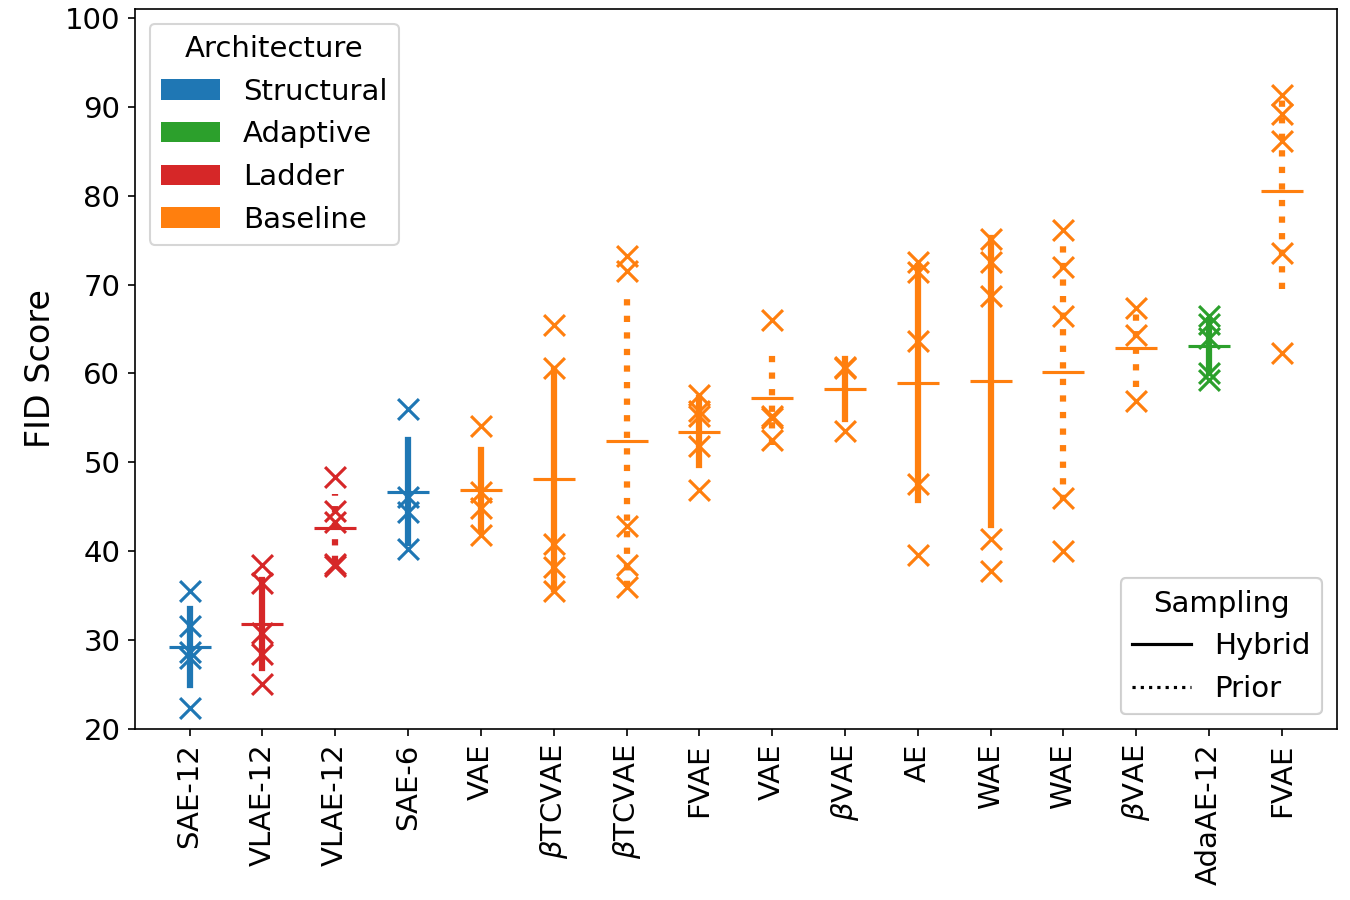

Figure seeds-generated saved as {'png', 'pdf'}


In [43]:
fg, ax = plt.subplots(figsize=info.fsize)

lbls = []
tps = set()
lss = {'hybrid': '-', 'prior': ':'}

for (g,t), ps in sorted(entries.items(), key=lambda x: np.mean(x[1])):
#     color = _get_color(display_order.index(g))
    color = _get_color(model_archs[g])
    
    tp = 'H' if t == 'hybrid' else 'P'
    title = f'{base_titles[g]} ({tp})'
    title = base_titles[g]
    tps.add(model_archs[g])
    i = len(lbls)
    lbls.append(title)
    
    mu, sigma = np.mean(ps), np.std(ps)
    
    rg = [min(ps), max(ps)]
    rg = [mu-sigma, mu+sigma]
    
    plt.plot([i, i], rg, color=color, lw=3, ls=lss[t])
    
    plt.scatter([i], [mu], marker='_', color=color, s=400)
    plt.scatter([i]*len(ps), ps, marker='x', color=color, s=100)
    pass



# legend_elements = [Patch(color=_get_color(i), label=base_titles[g]) for i, g in enumerate(display_order)]
# leg = plt.legend(handles=legend_elements, title='Model', ncol=4, loc=2)

legend_elements = [Patch(facecolor=_get_color(t), label=t) for t in arch_order if t in tps]
leg = plt.legend(handles=legend_elements, title='Architecture', loc=4 if dsname in {} else 2, 
                    framealpha=1 if dsname in {} else 0.8)

legend_elements1 = [mlines.Line2D([],[],color='k', ls=ls, label=lb.capitalize()) for lb, ls in lss.items()]
leg1 = plt.legend(handles=legend_elements1, title='Sampling', ncol=1, loc=4)
ax.add_artist(leg, )
ax.add_artist(leg1, )


plt.xticks(np.arange(len(lbls)), lbls, rotation='vertical')

plt.ylabel('FID Score')
# plt.title(f'{info.title} Generated Samples')
plt.ylim(20,101)
# plt.tight_layout();
plt.subplots_adjust(hspace=0.00, bottom=0.19, top=0.99, left=0.1, right=0.99);
util.save_figure('seeds-generated', **save_figure_kwargs);

<IPython.core.display.Javascript object>


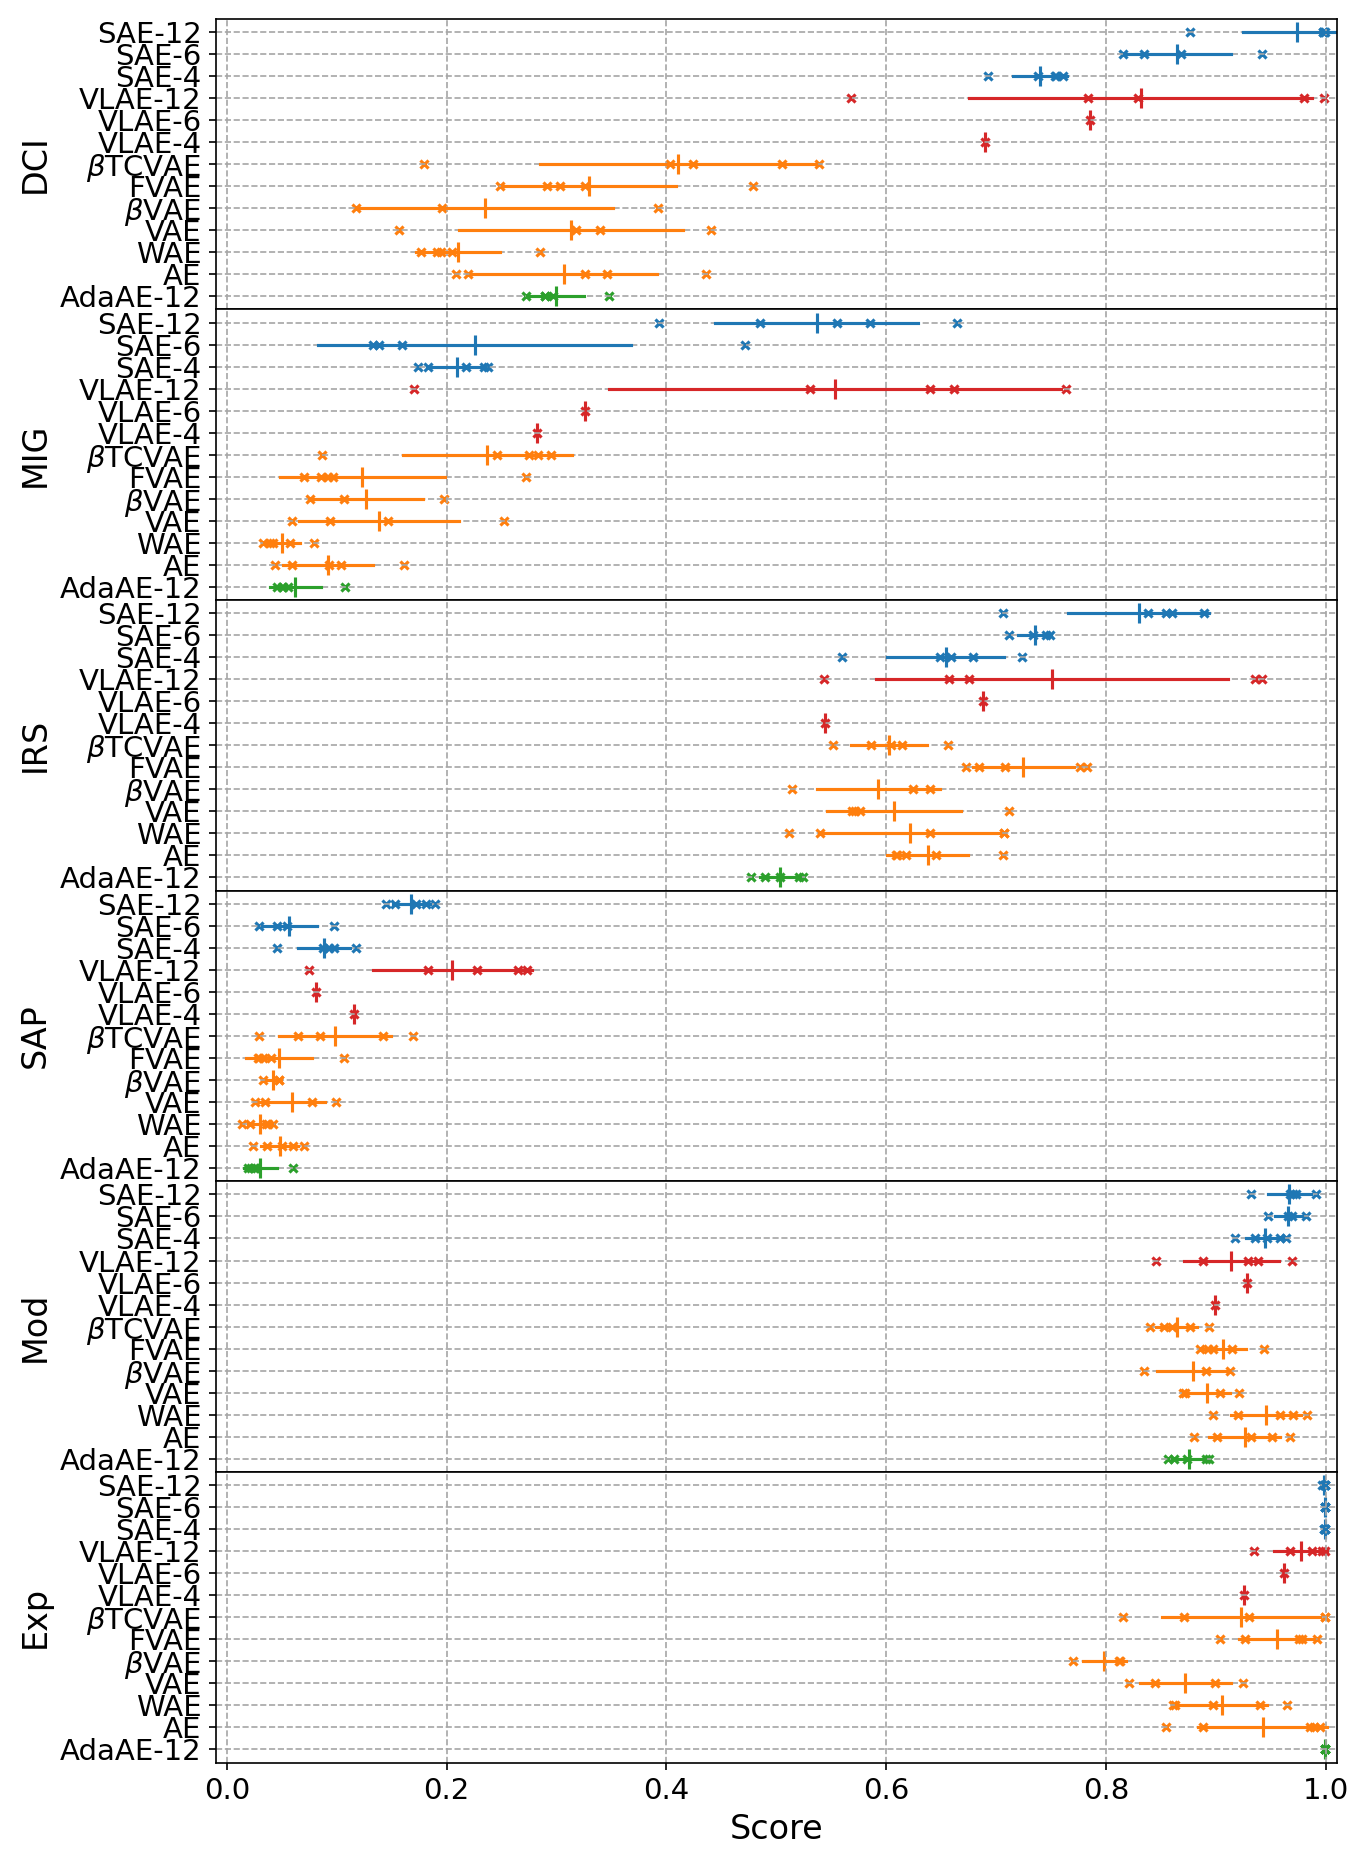

Figure seeds-metrics-main-est saved as {'png', 'pdf'}


In [30]:
picks = ['DCI', 'MIG', 'IRS', 'SAP', 'Mod', 'Exp']
pick_titles = {}
# picks = ['Response', 'DCI', 'IRS', ]
# pick_titles = {'Response': 'CDS',  'DCI': 'DCI-D'}

fg, axes = plt.subplots(len(picks), figsize=(9,2*len(picks) + 0.5), sharex=True)

for pick, ax in zip(picks, axes):
    plt.sca(ax)
    plt.gca().invert_yaxis()
    keys = []
    
    for i, g in enumerate(display_order):
        gr = groups[g]
        
        vals = [r.stats[pick] for r in gr]
        
        color = _get_color(model_archs[g])
        keys.append(base_titles[g])
        
        plt.scatter(vals, [i]*len(vals), c=color, marker='x', s=15);

        mu, sigma = np.mean(vals), np.std(vals)
        plt.plot([mu-sigma, mu+sigma], [i,i], c=color, ls='-', marker='');
        plt.scatter([mu], [i], c=color, marker='|', s=100);
    
    title = pick_titles.get(pick, pick)
    plt.ylabel(title)
    plt.yticks(np.arange(len(keys)), keys)
    plt.grid(which='major', color='0.65', linestyle='--', axis='both')
    
    
#     for i, name in enumerate(title_order):

#         g = groups_idxs[name]
#         model = models[g]

#         vals = np.array(model[pick])
        
#         plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

#         mu, sigma = np.mean(vals), np.std(vals)

#         plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
#         plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
# #         keys.append(info.group_names[g])
#         _key = mfixes.get(info.group_names[g],info.group_names[g])
#         keys.append(_key)
#         title = pick_titles.get(pick, pick)
# #         plt.title(pick)
#         plt.ylabel(title)
#     plt.yticks(np.arange(len(keys)), keys)
# #     if pick != picks[-1]:
# #         plt.xticks([])
# # plt.tight_layout()
plt.xlabel('Score')
plt.xlim(-0.01, 1.01)
plt.subplots_adjust(hspace=0.00, bottom=0.06, top=0.99, left=0.16, right=0.99)
util.save_figure('seeds-metrics-main-est', **save_figure_kwargs);

In [75]:
picks = ['DCI', 'MIG', 'IRS', 'Mod', 'Exp']
headers = ['Model'] + picks

tbl = np.array([[np.mean([r.stats[pick] for r in groups[g]]) for pick in picks] for i, g in enumerate(display_order)])

best = tbl.argmax(0)

fmt = '{:.3f}'
tbl = [[base_titles[g], *[(r'\textbf{' + fmt.format(v) + '}' if best[j]==i else fmt.format(v)) for j, v in enumerate(row)]] for i,(row,g) in enumerate(zip(tbl, display_order))]
    
print(tabulate(tbl, headers=headers, tablefmt='latex_raw'))

\begin{tabular}{llllll}
\hline
 Model        & DCI            & MIG            & IRS            & Mod            & Exp            \\
\hline
 SAE-12       & \textbf{0.374} & 0.148          & 0.564          & 0.928          & 0.869          \\
 SAE-6        & 0.295          & 0.074          & 0.535          & 0.879          & 0.840          \\
 VLAE-12      & 0.291          & \textbf{0.217} & 0.579          & 0.914          & 0.805          \\
 $\beta$TCVAE & 0.185          & 0.100          & 0.595          & 0.870          & 0.699          \\
 FVAE         & 0.095          & 0.028          & 0.522          & 0.904          & 0.729          \\
 $\beta$VAE   & 0.090          & 0.021          & \textbf{0.659} & 0.869          & 0.680          \\
 VAE          & 0.080          & 0.020          & 0.602          & 0.875          & 0.694          \\
 WAE          & 0.159          & 0.042          & 0.587          & 0.837          & 0.831          \\
 AE           & 0.143          & 0.048      

In [32]:

display_sel = ['AE S12', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'TCVAE 4', 'FVAE 1',]

<IPython.core.display.Javascript object>


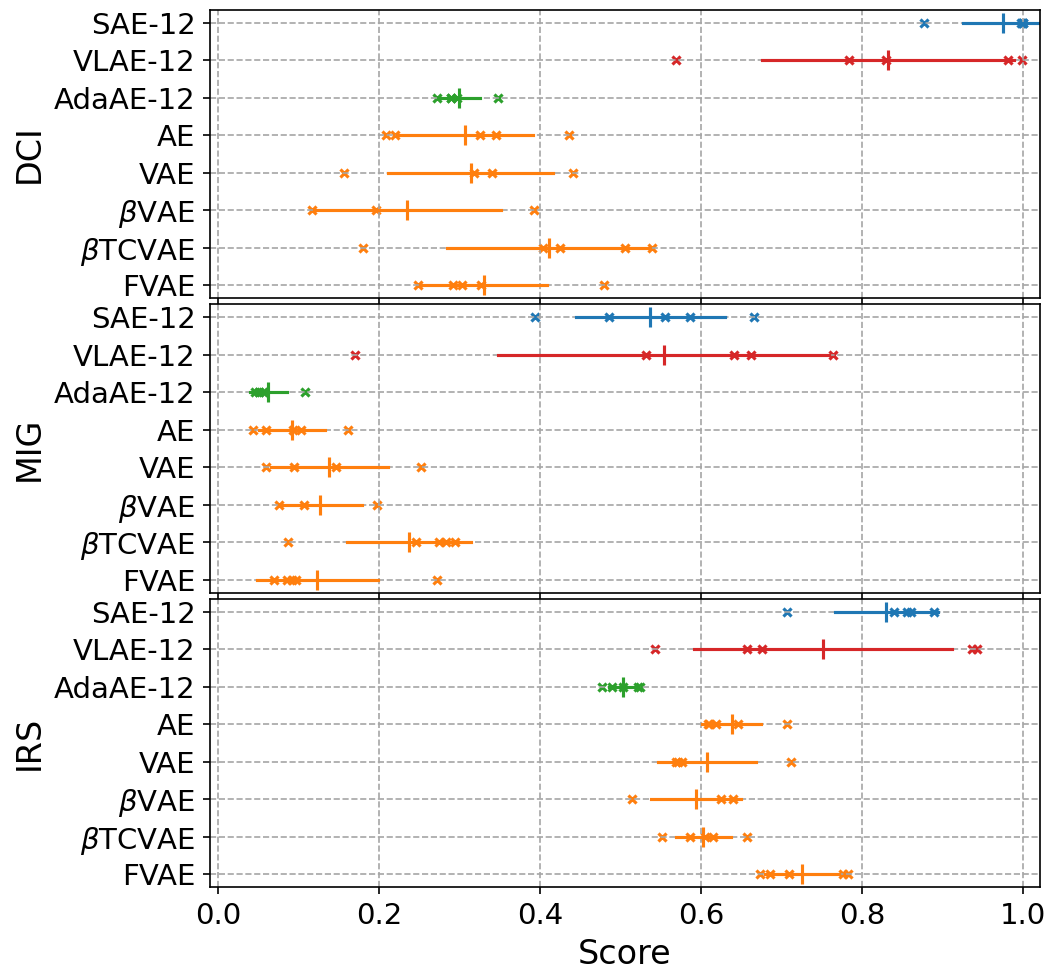

Figure seeds-metrics-sel2 saved as {'png', 'pdf'}


In [33]:
picks = ['DCI', 'MIG', 'IRS']
pick_titles = {}
# picks = ['Response', 'DCI', 'IRS', ]
# pick_titles = {'Response': 'CDS',  'DCI': 'DCI-D'}

fg, axes = plt.subplots(len(picks), figsize=(7,2*len(picks) + 0.5), sharex=True)

for pick, ax in zip(picks, axes):
    plt.sca(ax)
    plt.gca().invert_yaxis()
    keys = []
    
    for i, g in enumerate(display_sel):
        gr = groups[g]
        
        vals = [r.stats[pick] for r in gr]
        
        color = _get_color(model_archs[g])
        keys.append(base_titles[g])
        
        plt.scatter(vals, [i]*len(vals), c=color, marker='x', s=15);

        mu, sigma = np.mean(vals), np.std(vals)
        plt.plot([mu-sigma, mu+sigma], [i,i], c=color, ls='-', marker='');
        plt.scatter([mu], [i], c=color, marker='|', s=100);
    
    title = pick_titles.get(pick, pick)
    plt.ylabel(title)
    plt.yticks(np.arange(len(keys)), keys)
    plt.grid(which='major', color='0.65', linestyle='--', axis='both')
    
    
#     for i, name in enumerate(title_order):

#         g = groups_idxs[name]
#         model = models[g]

#         vals = np.array(model[pick])
        
#         plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

#         mu, sigma = np.mean(vals), np.std(vals)

#         plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
#         plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
# #         keys.append(info.group_names[g])
#         _key = mfixes.get(info.group_names[g],info.group_names[g])
#         keys.append(_key)
#         title = pick_titles.get(pick, pick)
# #         plt.title(pick)
#         plt.ylabel(title)
#     plt.yticks(np.arange(len(keys)), keys)
# #     if pick != picks[-1]:
# #         plt.xticks([])
# # plt.tight_layout()
plt.xlabel('Score')
plt.xlim(-0.01, 1.02)
plt.subplots_adjust(hspace=0.02, bottom=0.09, top=0.99, left=0.2, right=0.99)
util.save_figure('seeds-metrics-sel2', **save_figure_kwargs);

In [34]:
headers = ['Model'] + picks

tbl = np.array([[np.mean([r.stats[pick] for r in groups[g]]) for pick in picks] for i, g in enumerate(display_sel)])

best = tbl.argmax(0)

fmt = '{:.3f}'
tbl = [[base_titles[g], *[(r'\textbf{' + fmt.format(v) + '}' if best[j]==i else fmt.format(v)) for j, v in enumerate(row)]] for i,(row,g) in enumerate(zip(tbl, display_sel))]
    
print(tabulate(tbl, headers=headers, tablefmt='latex_raw'))

\begin{tabular}{llll}
\hline
 Model        & DCI            & MIG            & IRS            \\
\hline
 SAE-12       & \textbf{0.974} & 0.537          & \textbf{0.830} \\
 VLAE-12      & 0.832          & \textbf{0.553} & 0.751          \\
 AdaAE-12     & 0.299          & 0.062          & 0.503          \\
 AE           & 0.307          & 0.092          & 0.638          \\
 VAE          & 0.314          & 0.138          & 0.607          \\
 $\beta$VAE   & 0.235          & 0.127          & 0.593          \\
 $\beta$TCVAE & 0.410          & 0.237          & 0.603          \\
 FVAE         & 0.330          & 0.123          & 0.725          \\
\hline
\end{tabular}


In [158]:
tmpl = 'unbuffer fig eval --load {} --ident final --mode test'

In [159]:
raw = '''3ds_tcvae1_e-c12_d-c12_mish-b1_220126-001041	toy_tcvae1_e-c12_d-c12_mish-b1_220126-003646	sim_tcvae1_e-c12_d-c12_mish-b1_220126-003646	real_tcvae1_e-c12_d-c12_mish-b1_220126-003708	celeba_tcvae1_e-c16_d-c16_mish-b1_220126-002625
3ds_tcvae1_e-c12_d-c12_mish-b1-s2_220126-004444				
3ds_tcvae1_e-c12_d-c12_mish-b1-s3_220126-004435
				
3ds_tcvae1_e-c12_d-c12_mish-b1-s4_220126-004443				
3ds_tcvae1_e-c12_d-c12_mish-b1-s5_220126-004444				
3ds_tcvae1_e-c12_d-c12_mish-b4_220126-001031	toy_tcvae1_e-c12_d-c12_mish-b4_220126-003644	sim_tcvae1_e-c12_d-c12_mish-b4_220126-003647	real_tcvae1_e-c12_d-c12_mish-b4_220126-003646	celeba_tcvae1_e-c16_d-c16_mish-b4_220126-002615
3ds_tcvae4_e-c12_d-c12_mish-b4-s2_220126-004445				
3ds_tcvae4_e-c12_d-c12_mish-b4-s3_220126-004443				
3ds_tcvae4_e-c12_d-c12_mish-b4-s4_220126-004444				
3ds_tcvae4_e-c12_d-c12_mish-b4-s5_220126-004445				
3ds_fvae1_e-c12_d-c12_mish_220125-194411	toy_fvae1_e-c12_d-c12_mish_220126-003701	sim_fvae1_e-c12_d-c12_mish_220126-003646	real_fvae1_e-c12_d-c12_mish_220126-003704	celeba_fvae1_e-c16_d-c16_mish_220125-194732
3ds_fvae1_e-c12_d-c12_mish-s2_220126-004451				
3ds_fvae1_e-c12_d-c12_mish-s3_220126-004444				
3ds_fvae1_e-c12_d-c12_mish-s4_220126-004450				
3ds_fvae1_e-c12_d-c12_mish-s5_220126-004435				
3ds_fvae4_e-c12_d-c12_mish_220125-195100	toy_fvae4_e-c12_d-c12_mish_220126-123210	sim_fvae4_e-c12_d-c12_mish_220126-123212	real_fvae4_e-c12_d-c12_mish_220126-123212	celeba_fvae2_e-c16_d-c16_mish_220125-194748
3ds_fvae4_e-c12_d-c12_mish-s2_220126-004445				
3ds_fvae4_e-c12_d-c12_mish-s3_220126-004448				
3ds_fvae4_e-c12_d-c12_mish-s4_220126-004440				
3ds_fvae4_e-c12_d-c12_mish-s5_220126-004443				'''.split('\n')
ms = []
for line in raw:
    ms.extend([m for m in line.split('\t') if len(m)])
len(ms)

36

In [161]:
' '.join(m for m in ms if '3ds' not in m)

'toy_tcvae1_e-c12_d-c12_mish-b1_220126-003646 sim_tcvae1_e-c12_d-c12_mish-b1_220126-003646 real_tcvae1_e-c12_d-c12_mish-b1_220126-003708 celeba_tcvae1_e-c16_d-c16_mish-b1_220126-002625 toy_tcvae1_e-c12_d-c12_mish-b4_220126-003644 sim_tcvae1_e-c12_d-c12_mish-b4_220126-003647 real_tcvae1_e-c12_d-c12_mish-b4_220126-003646 celeba_tcvae1_e-c16_d-c16_mish-b4_220126-002615 toy_fvae1_e-c12_d-c12_mish_220126-003701 sim_fvae1_e-c12_d-c12_mish_220126-003646 real_fvae1_e-c12_d-c12_mish_220126-003704 celeba_fvae1_e-c16_d-c16_mish_220125-194732 toy_fvae4_e-c12_d-c12_mish_220126-123210 sim_fvae4_e-c12_d-c12_mish_220126-123212 real_fvae4_e-c12_d-c12_mish_220126-123212 celeba_fvae2_e-c16_d-c16_mish_220125-194748'

In [160]:
for m in ms:
    print(tmpl.format(m))

unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b1_220126-001041 --ident final --mode test
unbuffer fig eval --load toy_tcvae1_e-c12_d-c12_mish-b1_220126-003646 --ident final --mode test
unbuffer fig eval --load sim_tcvae1_e-c12_d-c12_mish-b1_220126-003646 --ident final --mode test
unbuffer fig eval --load real_tcvae1_e-c12_d-c12_mish-b1_220126-003708 --ident final --mode test
unbuffer fig eval --load celeba_tcvae1_e-c16_d-c16_mish-b1_220126-002625 --ident final --mode test
unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b1-s2_220126-004444 --ident final --mode test
unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b1-s3_220126-004435 --ident final --mode test
unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b1-s4_220126-004443 --ident final --mode test
unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b1-s5_220126-004444 --ident final --mode test
unbuffer fig eval --load 3ds_tcvae1_e-c12_d-c12_mish-b4_220126-001031 --ident final --mode test
unbuffer fig eval --load

In [ ]:
fig, ax = plt.subplots(figsize=info.fsize)
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
plt.xticks([])

# legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) 
#                    for name in title_order]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

# legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
#                           markersize=10, label='Hybrid'), 
#                     mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
#                           markersize=10, label='Prior')]

legend_elements1 = [Patch(facecolor='w', hatch='xx',label='Hybrid'), Patch(facecolor='w', hatch='oo',label='Prior')]
legend = plt.legend(handles=legend_elements, loc=4, title='Model', ncol=3, framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
else:
    plt.ylim(0,80)
plt.xlim(0-0.7, len(names)-0.3)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout();
# util.save_figure('seeds-generated', **save_figure_kwargs);

In [ ]:

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else 'oo') for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

In [ ]:
fig, ax = plt.subplots(figsize=info.fsize)
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
plt.xticks([])

# legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) 
#                    for name in title_order]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

# legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
#                           markersize=10, label='Hybrid'), 
#                     mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
#                           markersize=10, label='Prior')]

legend_elements1 = [Patch(facecolor='w', hatch='xx',label='Hybrid'), Patch(facecolor='w', hatch='oo',label='Prior')]
legend = plt.legend(handles=legend_elements, loc=4, title='Model', ncol=3, framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
else:
    plt.ylim(0,80)
plt.xlim(0-0.7, len(names)-0.3)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
# util.save_figure('seeds-generated', **save_figure_kwargs)
pass

In [ ]:

# run = fig.quick_run('load-run', load=ident)

In [4]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
root = Path(r'/is/ei/fleeb/workspace/chome/old_trained_nets')
nroot = Path(r'/is/ei/fleeb/workspace/chome/saved_models/sae_baselines/')
device = 'cuda'

In [5]:
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'$\beta$VAE', 'WAE10':'WAE1', 'WAE100':'WAE2', 'AE S12':'SAE-12', 'AE S4':'SAE-4', 'AE S6': 'SAE-6', 'VAE1 L12':'VLAE-12', 'AE S12 nosplit':'AdaAE-12',
              }
title_order = ['AE S12', 'AE S6', 'AE S4', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10']

title_order = ['AE S12', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 1', 'TCVAE 4', 'FVAE 1', 'FVAE 4']
mytitles = {}

In [6]:
ds = '3D-Shapes'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, 'VAE2 (2)': None, 'VAE2 (4)': None, 'VAE1 (2)': None, 
            'TCVAE 1': 'TCVAE', 'TCVAE 4': '$\beta$TCVAE', 'FVAE 1': 'FVAE', 'FVAE 4': '$\beta$FVAE'}
mytitles['AE S6'] = None
mytitles['AE S4'] = None

In [7]:
groups_idxs = {'AE':1, 'VAE1':5, 'VAE2':6, 'WAE10':8, 'WAE100': 7, 
          'AE S12':0, 'AE S4':4, 'AE S6':9, 'VAE1 L12':3, 'AE S12 nosplit':2, 'TCVAE 1': 0, 'TCVAE 4'}

titles = base_titles.copy()
titles.update(mytitles)

info.group_names = {v:titles.get(k, k) for k,v in groups_idxs.items()}

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[_unfix(k)] is not None}

sample_count = Counter(map(_unfix, [row for row in model_names.keys()]))

for typ, num in sample_count.items():
    if typ in titles:
        for n in range(1,num+1):
            key = _fix(typ, num=n)
            if key not in titles:
                titles[key] = f'{titles[typ]} {n}'
#             titles[_fix(typ, num=n)] = ''
        del titles[typ]

model_names = {k:v for k,v in model_names.items() if titles[k] is not None}
sample_count = Counter(map(_unfix, [row for row in model_names.keys()]))

def _is_jan(name):
    return 'fvae' in name.lower() or 'tcvae' in name.lower()

len(model_names), model_names.keys()

(52,
 dict_keys(['AE (1)', 'AE (2)', 'AE (3)', 'AE (4)', 'AE (5)', 'VAE1 (1)', 'VAE1 (3)', 'VAE1 (4)', 'VAE1 (5)', 'VAE2 (1)', 'VAE2 (3)', 'VAE2 (5)', 'WAE10 (1)', 'WAE10 (2)', 'WAE10 (3)', 'WAE10 (4)', 'WAE10 (5)', 'AE S12 (1)', 'AE S12 (2)', 'AE S12 (3)', 'AE S12 (4)', 'AE S12 (5)', 'AE S12 nosplit (1)', 'AE S12 nosplit (2)', 'AE S12 nosplit (3)', 'AE S12 nosplit (4)', 'AE S12 nosplit (5)', 'VAE1 L12 (1)', 'VAE1 L12 (2)', 'VAE1 L12 (3)', 'VAE1 L12 (4)', 'VAE1 L12 (5)', 'TCVAE 1 (1)', 'TCVAE 1 (2)', 'TCVAE 1 (3)', 'TCVAE 1 (4)', 'TCVAE 1 (5)', 'TCVAE 4 (1)', 'TCVAE 4 (2)', 'TCVAE 4 (3)', 'TCVAE 4 (4)', 'TCVAE 4 (5)', 'FVAE 1 (1)', 'FVAE 1 (2)', 'FVAE 1 (3)', 'FVAE 1 (4)', 'FVAE 1 (5)', 'FVAE 4 (1)', 'FVAE 4 (2)', 'FVAE 4 (3)', 'FVAE 4 (4)', 'FVAE 4 (5)']))

In [8]:
oruns = Run_Manager({k:v for k,v in model_names.items() if not _is_jan(k)}, root=root, override={'device':device}, pbar=tqdm)
nruns = Run_Manager({k:v for k,v in model_names.items() if _is_jan(k)}, root=nroot, override={'device':device}, pbar=tqdm)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
run = nruns[0]
run

SMARTRESULTS_INLINE_ONCLUSTER_TIMED_SAE_RUN:3ds_tcvae1_e-c12_d-c12_mish-b1_220126-001041

In [12]:
for run in tqdm(nruns):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
        
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    run.stats['hybrid_fid'] = run.get_datafile('eval/hybrid_fid', ext='npy')
    run.stats['prior_fid'] = run.get_datafile('eval/prior_fid', ext='npy')
    run.stats['rec_fid'] = run.get_datafile('eval/rec_fid', ext='npy')
    
    e = run.get_datafile('eval/scores')
    run.stats['IRS'] = e['irs']['score']
    run.stats['DCI'] = e['dci']['score']
    run.stats['SAP'] = e['sap']['score']
    run.stats['MIG'] = e['mig']['score']
    run.stats['Mod'] = e['modexp']['modularity_score']
    run.stats['Exp'] = e['modexp']['explicitness_score_test']

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# oruns.map(lambda run: run.get_records())

for run in tqdm(oruns):
    run.get_records()
    if not hasattr(run, 'stats'):
        run.stats = util.adict()

    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    path = run.get_path() / f'{info.cut}.pth.tar'
    if path.exists():
        e = torch.load(path)
    #     run.raw = e

        if 'rec_fid' in e:
            run.stats['rec_fid'] = e['rec_fid']
        if 'hybrid_fid' in e:
            run.stats['hybrid_fid'] = e['hybrid_fid']
        if 'prior_fid' in e:
            run.stats['prior_fid'] = e['prior_fid']

    path = run.get_path() / f'metrics.pth.tar'
    if path.exists():
        met = torch.load(path)

    #     run.raw_mets = mets

#         met = run.get_datafile('metrics')

        run.stats['IRS'] = met['scores']['IRS']['avg_score']
        run.stats['DCI'] = met['scores']['DCI']['disentanglement']
        run.stats['SAP'] = met['scores']['SAP']['SAP_score']
        run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
        run.stats['Mod'] = met['scores']['ModularityExplicitness']['modularity_score']
        run.stats['Exp'] = met['scores']['ModularityExplicitness']['explicitness_score_test']
        run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
        run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']

# runs.load_results('metrics');
# runs.load_results(info.cut);

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
runs = Run_Manager([], pbar=tqdm)
runs.extend(oruns)
runs.extend(nruns)
len(runs)

0it [00:00, ?it/s]

52

In [17]:
def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idxs[_unfix(run.ident)]
    run.title = titles[run.ident]
runs.map(_load_info);

  0%|          | 0/52 [00:00<?, ?it/s]

KeyError: 'TCVAE 1'

In [55]:
run = [r for i, r in enumerate(runs) if '3ds_ae0_e-c12_d-s12_mish_210125-050335' in str(r)][0]
run

INLINE_TIMED_SAE_RUN:3ds_ae0_e-c12_d-s12_mish_210125-050335

In [56]:
run.stats

t{'rec_fid':20.159259425899904, 'hybrid_fid':28.006216236925184, 'IRS':0.8388142759394108, 'DCI':0.9996164031589986, 'SAP':0.18930000000000002, 'MIG':0.6649653026424032, 'ModExp':0.9706202440859664, 'Response':0.9903311133384705, 'Fairness':None, 'rec_loss':3463.3564453125}

In [29]:
centers = {}
for r in runs:
    g = r.group
    if g not in centers:
        centers[g] = []
    centers[g].append([r.stats.rec_loss, r.stats.rec_fid])
for g, c in centers.items():
    centers[g] = np.array(c).mean(0)

<IPython.core.display.Javascript object>


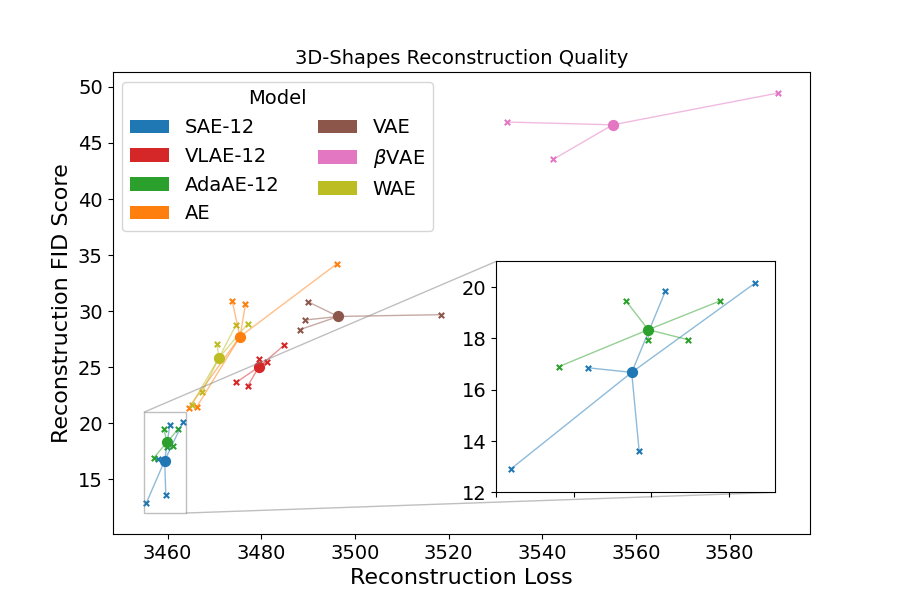

In [41]:
fig, ax = plt.subplots(figsize=info.fsize)


x1, x2, y1, y2 = 3455, 3464, 12, 21
eps = 0.05
axins = ax.inset_axes([0.55, eps+0.04, 0.45-eps, 0.5])
# axins.imshow(Z2, extent=extent, interpolation="nearest",
#           origin="lower")
# for child in ax.get_children():
#     axins.add_artist(child)
# sub region of the original image

for g, c in centers.items():
    plt.scatter(*c, color=_get_color(, s=50, zorder=3)
    axins.scatter(*c, color=info.colors[g], s=50, zorder=3)

objs = []
texts = []
tps = set()



# axes = [ax, axins]

for r in runs:
#         plt.sca(a)
    cx, cy = centers[r.group]
    x, y = r.stats.rec_loss, r.stats.rec_fid

#     arrowprops = dict(  # arrowstyle='simple',
#         arrowstyle='wedge',
#         # color=sup_color,
#         capstyle='round',
#         # linewidth=10, mutation_scale=150,
#         linewidth=0,  # headwidth=arrow_head,
#         facecolor=info.colors[r.group], edgecolor=None,

#              alpha=0.3,
# #         connectionstyle="arc3,rad=0.2",
#     )
#     plt.annotate('', xytext=(cx, cy), xy=(x, y),
#                  # xycoords='data',
#                  # textcoords='data',
#                  # lw=2,
#     #                  zorder=7,

#                  arrowprops=arrowprops)

    ax.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
    ax.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)


    axins.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
    axins.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)

#     texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.title, horizontalalignment='center',
#       verticalalignment='center',))
    tps.add(r.group)
#     break

# plt.sca(ax)
    
legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) for name in title_order if groups_idxs[name] in tps]
plt.legend(handles=legend_elements, title='Model', ncol=2, loc=2)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')


axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
# axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

# util.save_figure('seeds-rec', **save_figure_kwargs)
pass


In [42]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else 'oo') for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

49

<IPython.core.display.Javascript object>


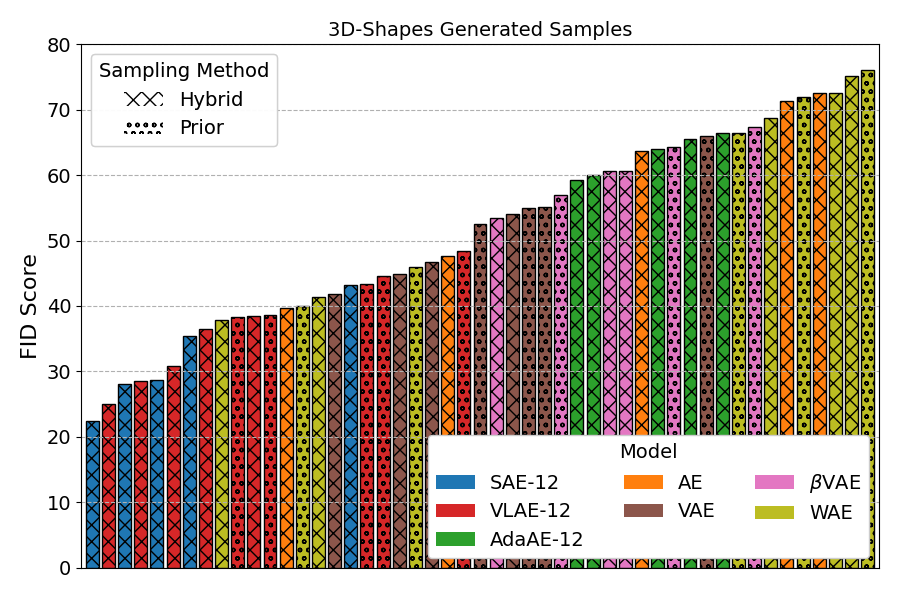

In [44]:
fig, ax = plt.subplots(figsize=info.fsize)
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
plt.xticks([])

# legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) 
#                    for name in title_order]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

# legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
#                           markersize=10, label='Hybrid'), 
#                     mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
#                           markersize=10, label='Prior')]

legend_elements1 = [Patch(facecolor='w', hatch='xx',label='Hybrid'), Patch(facecolor='w', hatch='oo',label='Prior')]
legend = plt.legend(handles=legend_elements, loc=4, title='Model', ncol=3, framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
else:
    plt.ylim(0,80)
plt.xlim(0-0.7, len(names)-0.3)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
# util.save_figure('seeds-generated', **save_figure_kwargs)
pass

In [50]:
models = {}

for r in runs:
    
    g = r.group
    
    if g not in models:
        models[g] = {}
    
    stats = models[g]
    
    for stat, val in r.stats.items():
        if stat not in stats:
            stats[stat] = []
        stats[stat].append(val)

In [51]:
mfixes = {'AE S12': 'SAE12', 'VAE1 L12': 'VLAE12', 'AE S12 nosplit': 'AdaAE12', 'VAE1':'VAE','VAE2':r'$\beta$VAE', 'WAE10': 'WAE'}

<IPython.core.display.Javascript object>


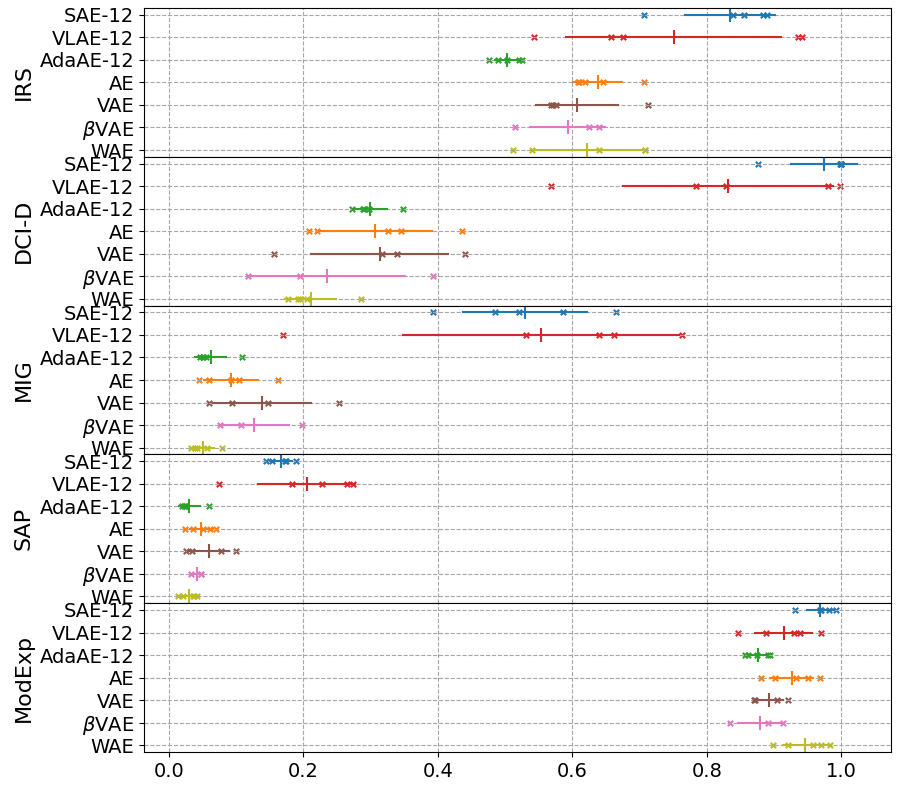

In [52]:
picks = ['Response', 'IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
picks = ['IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
# picks = ['Response', 'DCI', 'IRS', ]
pick_titles = {'Response': 'CDS',  'DCI': 'DCI-D'}

fig, axes = plt.subplots(len(picks), figsize=(9,1.5*len(picks) + 0.5), sharex=True)

for pick, ax in zip(picks, axes):
    plt.sca(ax)
    plt.gca().invert_yaxis()
    keys = []
    for i, name in enumerate(title_order):

        g = groups_idxs[name]
        model = models[g]

        vals = np.array(model[pick])
        
        if pick == 'Response':
            vals -= 1/6
            vals /= 5/6

        plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

        mu, sigma = np.mean(vals), np.std(vals)

        plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
        plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
#         keys.append(info.group_names[g])
        _key = mfixes.get(info.group_names[g],info.group_names[g])
        keys.append(_key)
        title = pick_titles.get(pick, pick)
#         plt.title(pick)
        plt.ylabel(title)
    plt.yticks(np.arange(len(keys)), keys)
#     if pick != picks[-1]:
#         plt.xticks([])
# plt.tight_layout()
    plt.grid(which='major', color='0.65', linestyle='--', axis='both')
plt.subplots_adjust(hspace=0.00, bottom=0.06, top=0.99, left=0.16, right=0.99)
# util.save_figure('seeds-metrics-main-est', **save_figure_kwargs)
pass

# old

In [34]:
# met = run.get_results('metrics')
# met.keys()

dict_keys(['scores', 'results'])

In [35]:
# for m, k in met['results'].items():
#     print(m, '  ', k.keys())

IRS    dict_keys(['disentanglement_scores', 'parents', 'IRS_matrix', 'max_deviations'])
Fairness    dict_keys(['mean_fairness:mean_pred:mean_sens'])
UnsupervisedMetrics    dict_keys(['covariance_matrix', 'mutual_info_score'])
ModularityExplicitness    dict_keys([])
SAP    dict_keys(['SAP_matrix'])
MIG    dict_keys(['entropy'])
DCI    dict_keys(['importance_matrix'])
LatentResponses    dict_keys(['response_mat', 'covariance', 'factor_responses', 'factor_responses_q'])


In [36]:
def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_results(info.cut)
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
    
    met = run.get_results('metrics')
    
    run.stats['IRS'] = met['scores']['IRS']['avg_score']
    run.stats['DCI'] = met['scores']['DCI']['disentanglement']
    run.stats['SAP'] = met['scores']['SAP']['SAP_score']
    run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
    run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
    run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
    run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']
    
    if not hasattr(run, 'data'):
        run.data = util.adict()
    run.data['IRS'] = met['results']['IRS']['IRS_matrix']
    run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
    run.data['SAP'] = met['results']['SAP']['SAP_matrix']
    run.data['DCI'] = met['results']['DCI']['importance_matrix']
    run.data['Response'] = met['results']['LatentResponses']['response_mat']
    run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
    
runs.map(_load_fid);

  0%|          | 0/32 [00:00<?, ?it/s]

In [39]:
centers = {}
for r in runs:
    g = r.group
    if g not in centers:
        centers[g] = []
    centers[g].append([r.stats.rec_loss, r.stats.rec_fid])
for g, c in centers.items():
    centers[g] = np.array(c).mean(0)

<IPython.core.display.Javascript object>


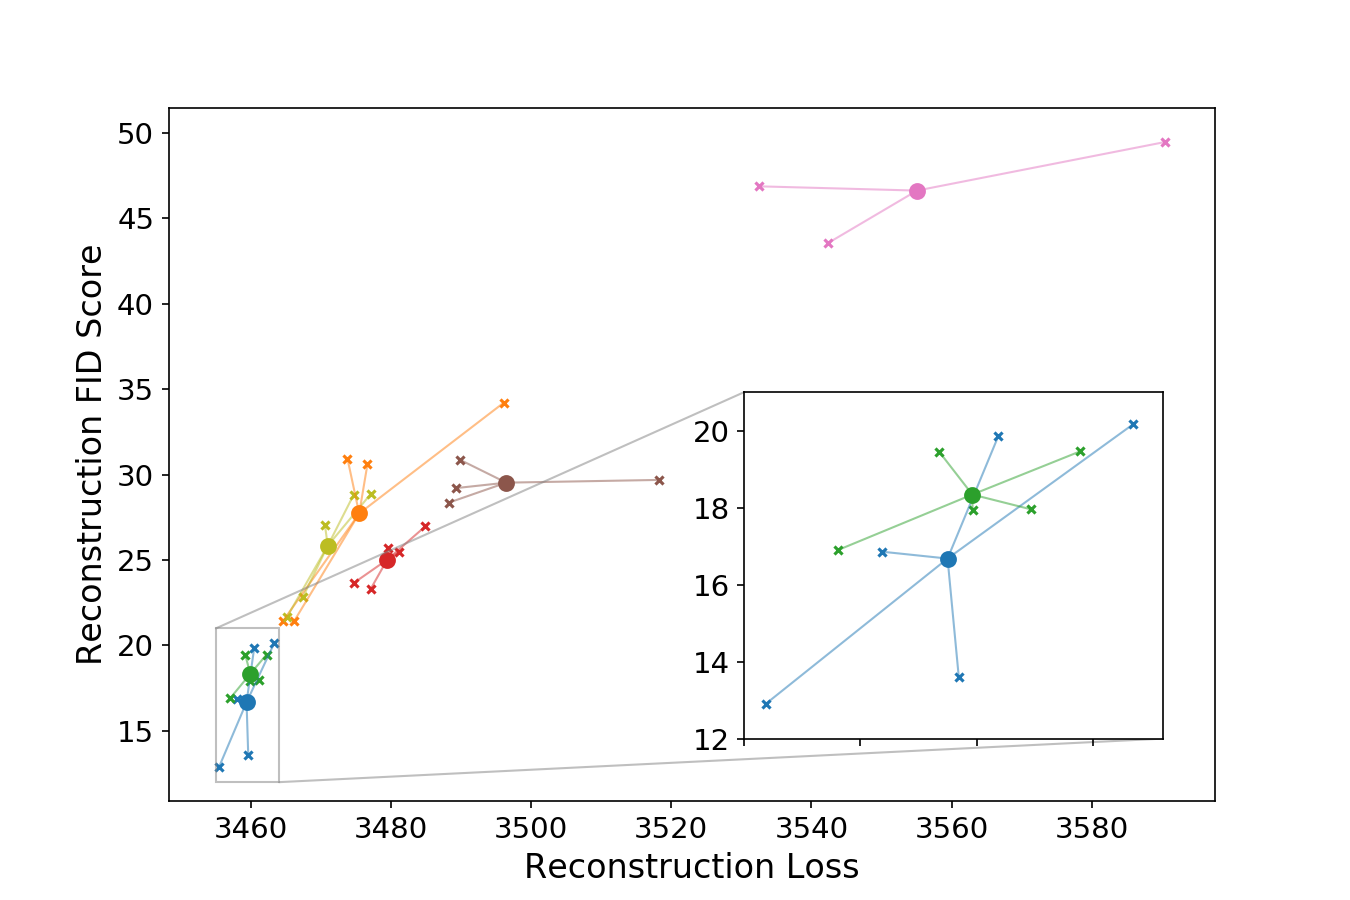

In [24]:
# fig, ax = plt.subplots(figsize=info.fsize)


# x1, x2, y1, y2 = 3455, 3464, 12, 21
# eps = 0.05
# axins = ax.inset_axes([0.55, eps+0.04, 0.45-eps, 0.5])
# # axins.imshow(Z2, extent=extent, interpolation="nearest",
# #           origin="lower")
# # for child in ax.get_children():
# #     axins.add_artist(child)
# # sub region of the original image

# for g, c in centers.items():
#     plt.scatter(*c, color=info.colors[g], s=50, zorder=3)
#     axins.scatter(*c, color=info.colors[g], s=50, zorder=3)

# objs = []
# texts = []
# tps = set()



# # axes = [ax, axins]

# for r in runs:
# #         plt.sca(a)
#     cx, cy = centers[r.group]
#     x, y = r.stats.rec_loss, r.stats.rec_fid

# #     arrowprops = dict(  # arrowstyle='simple',
# #         arrowstyle='wedge',
# #         # color=sup_color,
# #         capstyle='round',
# #         # linewidth=10, mutation_scale=150,
# #         linewidth=0,  # headwidth=arrow_head,
# #         facecolor=info.colors[r.group], edgecolor=None,

# #              alpha=0.3,
# # #         connectionstyle="arc3,rad=0.2",
# #     )
# #     plt.annotate('', xytext=(cx, cy), xy=(x, y),
# #                  # xycoords='data',
# #                  # textcoords='data',
# #                  # lw=2,
# #     #                  zorder=7,

# #                  arrowprops=arrowprops)

#     ax.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
#     ax.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)


#     axins.plot([cx, x], [cy, y], ls='-', marker='', color=info.colors[r.group], lw=1, alpha=0.5)
#     axins.scatter(x, y, color=info.colors[r.group], marker='x', zorder=2, s=15)

# #     texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.title, horizontalalignment='center',
# #       verticalalignment='center',))
#     tps.add(r.group)
# #     break

# # plt.sca(ax)
    
# # legend_elements = [Patch(facecolor=info.colors[groups[name]], label=info.group_names[groups[name]]) for name in title_order if groups[name] in tps]
# # plt.legend(handles=legend_elements, title='Model', ncol=2, loc=2)
# plt.xlabel('Reconstruction Loss')
# plt.ylabel('Reconstruction FID Score')
# # plt.title(f'{info.title} Reconstruction Quality')


# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels('')
# # axins.set_yticklabels('')

# ax.indicate_inset_zoom(axins)

# # util.save_figure('seeds-rec', **save_figure_kwargs)
# pass


In [25]:
# scores = []
# groups = []
# typs = []
# names = []

# for r in runs:
#     if 'hybrid_fid' in r.stats:
#         scores.append(r.stats.hybrid_fid)
#         groups.append(r.group)
#         typs.append('hyb')
#         names.append(r.title)
#     if 'prior_fid' in r.stats:
#         scores.append(r.stats.prior_fid)
#         groups.append(r.group)
#         typs.append('prior')
#         names.append(r.title)

# scores = np.array(scores)
# groups = np.array(groups)
# typs = np.array(typs)
# names = np.array(names)

# order = np.argsort(scores)
# scores = scores[order]
# groups = groups[order]
# typs = typs[order]
# names = names[order]

# eclrs = [('xx' if t == 'hyb' else 'oo') for t in typs]
# clrs = [info.colors[g] for g in groups]

# len(scores)

49

<IPython.core.display.Javascript object>


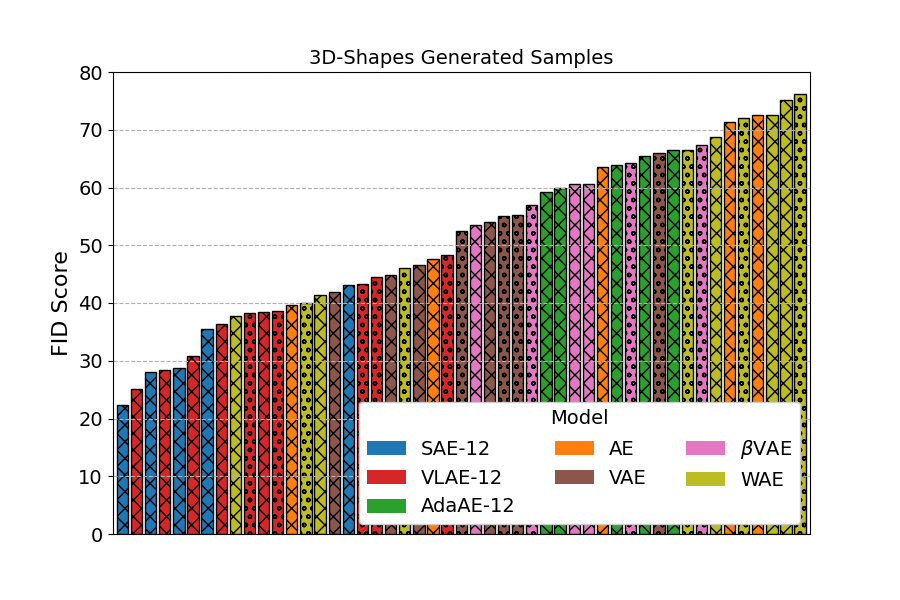

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

In [45]:
# fig, ax = plt.subplots(figsize=info.fsize)
# # texts = []
# # tps = set()
# x = np.arange(len(names))
# for i,s,c,h in zip(x,scores,clrs,eclrs):
#     plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
# plt.xticks(x, names, rotation='vertical')
# plt.xticks([])

# legend_elements = [Patch(facecolor=info.colors[groups_idxs[name]], label=info.group_names[groups_idxs[name]]) 
#                    for name in title_order]
# # legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

# legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
#                           markersize=10, label='Hybrid'), 
#                     mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
#                           markersize=10, label='Prior')]
# legend = plt.legend(handles=legend_elements, loc=4, title='Model', ncol=3, framealpha=1)
# # plt.xlabel('Reconstruction Loss')
# plt.ylabel('FID Score')
# plt.title(f'{info.title} Generated Samples')
# # plt.yscale('log')
# if info.title == 'CelebA':
#     plt.ylim(80,150)
# else:
#     plt.ylim(0,80)
# plt.xlim(0-0.7, len(names)-0.3)
# # plt.yticks(s,map(str,s))
# plt.grid(linestyle='--',axis='y')

# # legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=2, title='Sampling Method')
# ax.add_artist(legend1, )
# ax.add_artist(legend)
# plt.tight_layout()
# # util.save_figure('seeds-generated', **save_figure_kwargs)
# pass

<IPython.core.display.Javascript object>


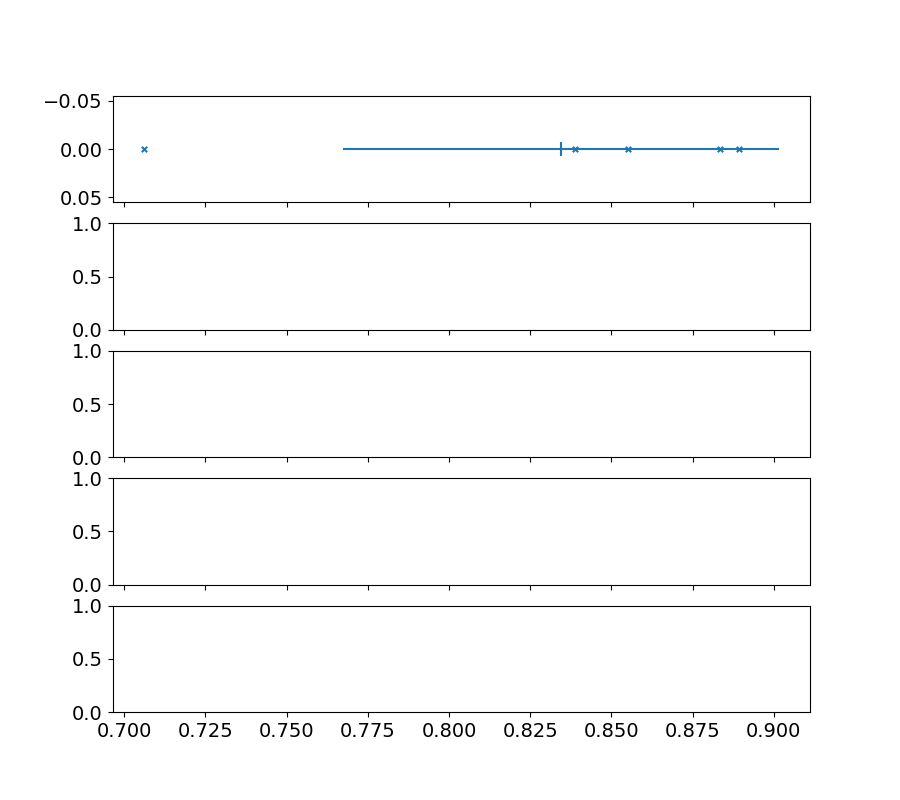

NameError: name 'mfixes' is not defined

In [49]:
# picks = ['Response', 'IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
# picks = ['IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
# # picks = ['Response', 'DCI', 'IRS', ]
# pick_titles = {'Response': 'CDS',  'DCI': 'DCI-D'}

# fig, axes = plt.subplots(len(picks), figsize=(9,1.5*len(picks) + 0.5), sharex=True)

# for pick, ax in zip(picks, axes):
#     plt.sca(ax)
#     plt.gca().invert_yaxis()
#     keys = []
#     for i, name in enumerate(title_order):

#         g = groups_idxs[name]
#         model = models[g]

#         vals = np.array(model[pick])
        
#         if pick == 'Response':
#             vals -= 1/6
#             vals /= 5/6

#         plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

#         mu, sigma = np.mean(vals), np.std(vals)

#         plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
#         plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
# #         keys.append(info.group_names[g])
#         _key = mfixes.get(info.group_names[g],info.group_names[g])
#         keys.append(_key)
#         title = pick_titles.get(pick, pick)
# #         plt.title(pick)
#         plt.ylabel(title)
#     plt.yticks(np.arange(len(keys)), keys)
# #     if pick != picks[-1]:
# #         plt.xticks([])
# # plt.tight_layout()
#     plt.grid(which='major', color='0.65', linestyle='--', axis='both')
# plt.subplots_adjust(hspace=0.00, bottom=0.06, top=0.99, left=0.16, right=0.99)
# util.save_figure('seeds-metrics-main-est', **save_figure_kwargs)
# pass

In [28]:
run.results[info.cut].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid', '_size_key'])

In [40]:
models = {}

for r in runs:
    
    g = r.group
    
    if g not in models:
        models[g] = {}
    
    stats = models[g]
    
    for stat, val in r.stats.items():
        if stat not in stats:
            stats[stat] = []
        stats[stat].append(val)

In [41]:
pick = 'Response'
# names = title_order.copy()
# keys = [info.group_names[groups[name]] for name in names]

In [42]:
info

t{'fsize':(9, 6), 'cut':'final', 'device':'cuda', 'results_name':'final', 'small_font_size':14, 'medium_font_size':16, 'large_font_size':18, 'colors':{0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}, 'group_names':{1: 'AE', 5: 'VAE', 6: '$\\beta$VAE', 8: 'WAE', 7: None, 0: 'SAE-12', 4: None, 9: None, 3: 'VLAE-12', 2: 'AdaAE-12'}, 'title':'3D-Shapes'}

In [43]:
info.group_names

{1: 'AE',
 5: 'VAE',
 6: '$\\beta$VAE',
 8: 'WAE',
 7: None,
 0: 'SAE-12',
 4: None,
 9: None,
 3: 'VLAE-12',
 2: 'AdaAE-12'}

In [44]:
mfixes = {'AE S12': 'SAE12', 'VAE1 L12': 'VLAE12', 'AE S12 nosplit': 'AdaAE12', 'VAE1':'VAE','VAE2':r'$\beta$VAE', 'WAE10': 'WAE'}

In [45]:
g

3

In [46]:
info.group_names[g]

'VLAE-12'

<IPython.core.display.Javascript object>


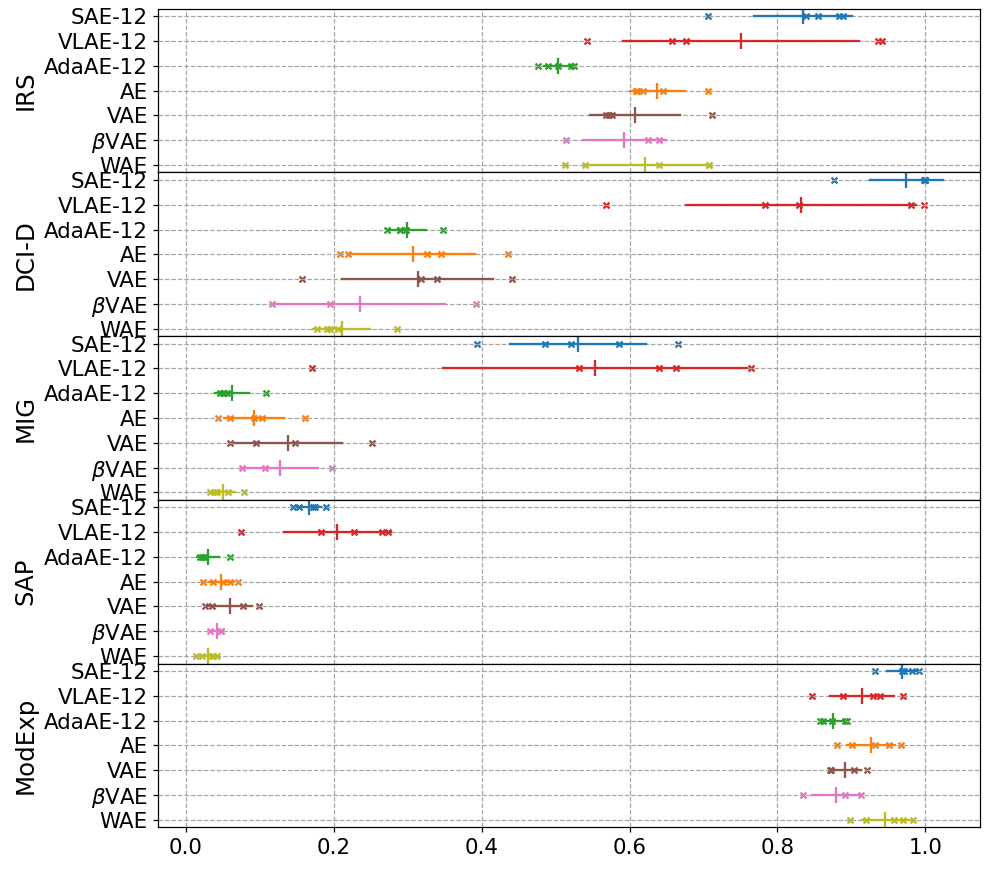

Figure seeds-metrics-main-est saved as {'png', 'pdf'}


In [48]:
picks = ['Response', 'IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
picks = ['IRS', 'DCI', 'MIG', 'SAP', 'ModExp']
# picks = ['Response', 'DCI', 'IRS', ]
pick_titles = {'Response': 'CDS',  'DCI': 'DCI-D'}

fig, axes = plt.subplots(len(picks), figsize=(9,1.5*len(picks) + 0.5), sharex=True)

for pick, ax in zip(picks, axes):
    plt.sca(ax)
    plt.gca().invert_yaxis()
    keys = []
    for i, name in enumerate(title_order):

        g = groups_idxs[name]
        model = models[g]

        vals = np.array(model[pick])
        
        if pick == 'Response':
            vals -= 1/6
            vals /= 5/6

        plt.scatter(vals, [i]*len(vals), c=info.colors[g], marker='x', s=15);

        mu, sigma = np.mean(vals), np.std(vals)

        plt.plot([mu-sigma, mu+sigma], [i,i], c=info.colors[g], ls='-', marker='');
        plt.scatter([mu], [i], c=info.colors[g], marker='|', s=100);
#         keys.append(info.group_names[g])
        _key = mfixes.get(info.group_names[g],info.group_names[g])
        keys.append(_key)
        title = pick_titles.get(pick, pick)
#         plt.title(pick)
        plt.ylabel(title)
    plt.yticks(np.arange(len(keys)), keys)
#     if pick != picks[-1]:
#         plt.xticks([])
# plt.tight_layout()
    plt.grid(which='major', color='0.65', linestyle='--', axis='both')
plt.subplots_adjust(hspace=0.00, bottom=0.06, top=0.99, left=0.16, right=0.99)
util.save_figure('seeds-metrics-main-est', **save_figure_kwargs)
pass

In [23]:
seeds = {}
for r in runs:
    
    if r.group not in seeds:
        seeds[r.group] = []
    
    seeds[r.group].append(r)
len(seeds)

9

In [24]:
idx = 0

In [25]:
run.data.keys()

odict_keys(['IRS', 'cov', 'SAP', 'DCI', 'Response', 'FactorResponse'])

In [63]:
allRs = {k:torch.stack([r.data['FactorResponse'].min(1)[0].max(-1)[0] for r in seeds[g]]) for k,g in groups.items() if g in seeds}
allMs = {k:torch.stack([r.data['Response'] for r in seeds[g]]) for k,g in groups.items() if g in seeds}
allRs.keys()

dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S12', 'AE S4', 'AE S6', 'VAE1 L12', 'AE S12 nosplit'])

In [195]:
model = 'AE S12'
# model = 'AE S6'
# model = 'AE S4'
# model = 'AE'

g = groups[model]

In [196]:
irs = [r.data['IRS'] for r in seeds[g]]
sap = [r.data['SAP'] for r in seeds[g]]
dci = [r.data['DCI'].T for r in seeds[g]]
Rs = allRs[model]
Ms = allMs[model]

In [197]:
avg_title_order = title_order.copy()
avg_title_order = ['AE S12', 'VAE1 L12', 'AE S6', 'AE S4', 'VAE1', 'AE S12 nosplit']
H, W = util.calc_tiling(len(avg_title_order))
H, W = W,H
H, W

(3, 2)

In [198]:
# fg, axes = plt.subplots(H,W, figsize=(7,6))
# axes = axes.reshape(-1)

# for ax, title in zip(axes, avg_title_order):
#     plt.sca(ax)
    
#     Rs = allRs[title]
    
# #     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
#     util.plot_mat(Rs.mean(0), val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':10});
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(info.group_names[groups[title]], pad=-3)
# plt.subplots_adjust(hspace=0.04, wspace=0.02, bottom=0.01, top=0.97, left=0.01, right=0.99)
# util.save_figure('avg-responses', **save_figure_kwargs)

In [199]:
# util.plot_mat(Rs.mean(0), val_fmt=2, figax=None);
# plt.xticks([])
# plt.yticks([])
# pass

In [200]:
allMats = {'Response':Ms, 'FactorResponse':Rs, 'DCI': dci}

In [207]:
mat_name = 'Response'
mat_name = 'DCI'
mat_name = 'FactorResponse'

In [208]:
nax = len(dci)
H,W = util.calc_tiling(nax)
H,W

(1, 5)

<IPython.core.display.Javascript object>


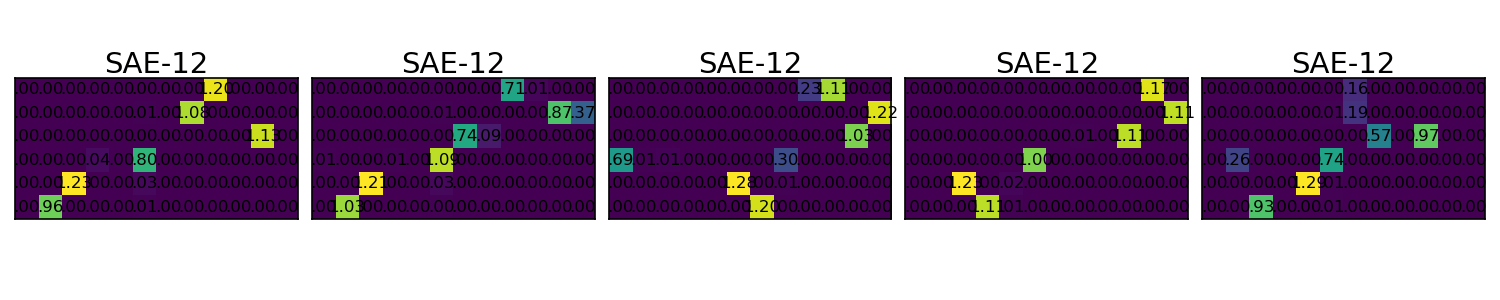

Figure seeds_AE-S12_FactorResponse_matrices saved as {'png', 'pdf'}


In [209]:
fg, axes = plt.subplots(H,W, figsize=(10,3) if mat_name == 'Response' else (10,2))
axes = axes.reshape(-1)

content = allMats[mat_name]

for ax, mat in zip(axes, content):
    plt.sca(ax)
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(mat, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(info.group_names[groups[model]], pad=-1)

    
# for i in range(len(allRs), nax):
#     axes[i].axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.05, bottom=0.04, top=0.97, left=0.01, right=0.99)
modelname = model.replace(' ','-')
util.save_figure(f'seeds_{modelname}_{mat_name}_matrices', **save_figure_kwargs)

In [ ]:
factor_order =  ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
factors = {'floor_hue': 'Floor Hue', 'wall_hue': 'Wall Hue', 'object_hue': 'Object Hue', 'scale': 'Scale', 'shape': 'Shape', 'orientation': 'Orientation'}


In [ ]:
fg, axes = plt.subplots(H,W, figsize=(15,10) if mat_name == 'Response' else (15,5.5))
axes = axes.reshape(-1)

for ax, title in zip(axes, title_order):
    plt.sca(ax)
    
    Rs = allRs[title]
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(Rs, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(run_idents[title].title, pad=-1)

    
for i in range(len(allRs), nax):
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.02, bottom=0.04, top=0.97, left=0.01, right=0.99)
util.save_figure(f'{dscode}_{mat_name}_matrices', **save_figure_kwargs)

In [ ]:
M, F, R = run.data['Response'], run.data['FactorResponse'].min(1)[0].max(-1)[0], run.data['DCI'].T
M.shape, F.shape, R.shape